In [3]:
import os
import glob
import numpy as np
from PIL import Image, ImageOps
import tensorflow as tf
import gradio as gr
import cv2
import matplotlib.pyplot as plt

from utils.prediction import get_sr_image
from utils.config import config



In [4]:
def load_image(path):
    img = Image.open(path)
    
    was_grayscale = len(img.getbands()) == 1
    
    if was_grayscale or len(img.getbands()) == 4:
        img = img.convert('RGB')
    
    return was_grayscale, np.array(img)

In [5]:
# model_name = "srresnet"
model_name = "srgan"

In [6]:
model_key = f"{model_name}"

In [7]:
weights_directory = os.path.abspath(f"weights/{model_key}")

file_path = os.path.join(weights_directory, "generator.h5")

In [8]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, BatchNormalization, Add, Lambda
from tensorflow.python.keras.layers import PReLU

from utils.normalization import normalize_01, denormalize_m11


upsamples_per_scale = {
    2: 1,
    4: 2,
    8: 3
}


def pixel_shuffle(scale):
    return lambda x: tf.nn.depth_to_space(x, scale)


def upsample(x_in, num_filters):
    x = Conv2D(num_filters, kernel_size=3, padding='same')(x_in)
    x = Lambda(pixel_shuffle(scale=2))(x)
    return PReLU(shared_axes=[1, 2])(x)


def residual_block(block_input, num_filters, momentum=0.8):
    x = Conv2D(num_filters, kernel_size=3, padding='same')(block_input)
    x = BatchNormalization(momentum=momentum)(x)
    x = PReLU(shared_axes=[1, 2])(x)
    x = Conv2D(num_filters, kernel_size=3, padding='same')(x)
    x = BatchNormalization(momentum=momentum)(x)
    x = Add()([block_input, x])
    return x


def build_srresnet(scale=4, num_filters=64, num_res_blocks=16):
    if scale not in upsamples_per_scale:
        raise ValueError(f"available scales are: {upsamples_per_scale.keys()}")

    num_upsamples = upsamples_per_scale[scale]

    lr = Input(shape=(None, None, 3))
    x = Lambda(normalize_01)(lr)

    x = Conv2D(num_filters, kernel_size=9, padding='same')(x)
    x = x_1 = PReLU(shared_axes=[1, 2])(x)

    for _ in range(num_res_blocks):
        x = residual_block(x, num_filters)

    x = Conv2D(num_filters, kernel_size=3, padding='same')(x)
    x = BatchNormalization()(x)
    x = Add()([x_1, x])

    for _ in range(num_upsamples):
        x = upsample(x, num_filters * 4)

    x = Conv2D(3, kernel_size=9, padding='same', activation='tanh')(x)
    sr = Lambda(denormalize_m11)(x)

    return Model(lr, sr)


In [9]:


model = build_srresnet(scale=4)

os.makedirs(weights_directory, exist_ok=True)
weights_file = f'{weights_directory}/generator.h5'


model.load_weights(weights_file)

results_path = f"output/{model_key}/"

os.makedirs(results_path, exist_ok=True)



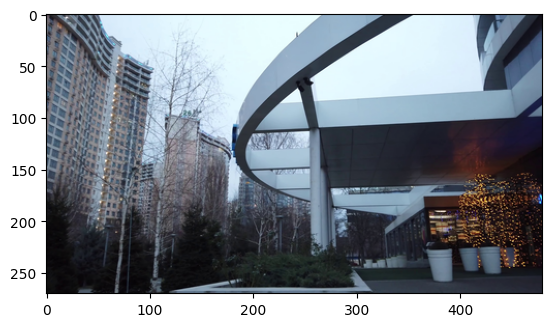

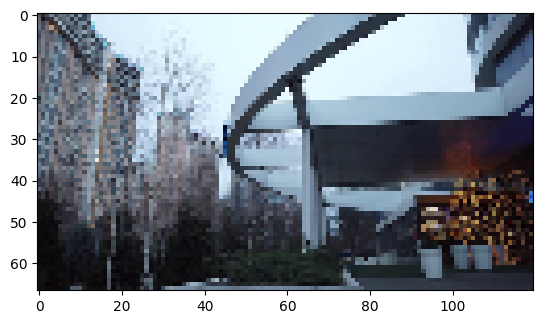

1/1 [==============================] - 1s 1s/step


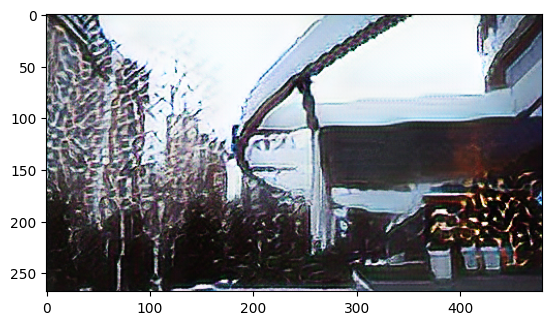

InvalidArgumentError: {{function_node __wrapped__SquaredDifference_device_/job:localhost/replica:0/task:0/device:CPU:0}} Incompatible shapes: [268,480,3] vs. [270,480,3] [Op:SquaredDifference] name: 

In [ ]:
image_paths = glob.glob("input/*")

psnr_values = []
ssim_values = []
for image_path in image_paths[:20]:
    # Degrade the image
    hr = cv2.imread(image_path)
    hr = cv2.cvtColor(hr, cv2.COLOR_BGR2RGB)
    if image_path==image_paths[0]:
        plt.imshow(hr)
        plt.show()
    lr = cv2.resize(hr, (hr.shape[1] // 4, hr.shape[0] // 4), interpolation=cv2.INTER_CUBIC)
    if image_path==image_paths[0]:
        plt.imshow(lr)
        plt.show()
    sr = get_sr_image(model, lr)
    sr = np.array(sr)
    if image_path==image_paths[0]:
        plt.imshow(sr)
        plt.show()
    # Compute the PSNR 
    psnr = tf.image.psnr(sr, hr, max_val=255)
    
    # Compute the SSIM
    ssim = tf.image.ssim(sr, hr, max_val=255, filter_size=11, filter_sigma=1.5, k1=0.01, k2=0.03)
    
    print(f"PSNR: {psnr} dB")
    print(f"SSIM: {ssim}")
    psnr_values.append(psnr)
    ssim_values.append(ssim)




In [ ]:
print(f"Average PSNR: {np.mean(psnr_values)} dB")
print(f"Average SSIM: {np.mean(ssim_values)}")

Average PSNR: 18.24386215209961 dB
Average SSIM: 0.5464171767234802


In [10]:
def use_srresnet(image):
    
    lr = image
    
    model = build_srresnet(scale=4)
    model_key = f"srresnet"
    weights_directory = os.path.abspath(f"weights/{model_key}")
    os.makedirs(weights_directory, exist_ok=True)
    weights_file = f'{weights_directory}/generator.h5'
    model.load_weights(weights_file)

    sr = get_sr_image(model, lr)
    
    return sr

def use_srgan(image):
        
        lr = image
        
        model = build_srresnet(scale=4)
        model_key = f"srgan"
        weights_directory = os.path.abspath(f"weights/{model_key}")
        os.makedirs(weights_directory, exist_ok=True)
        weights_file = f'{weights_directory}/generator.h5'
        model.load_weights(weights_file)
    
        sr = get_sr_image(model, lr)
        
        return sr


In [ ]:
with gr.Blocks() as demo:

    image = gr.Image(label="Input low resolution image")
    with gr.Row():
        
        button_use_srresnet = gr.Button("Use SRResNet")
        button_use_srgan = gr.Button("Use SRGAN")
    
    with gr.Row():
        output_srresnet = gr.Image(label="Output SRResNet")
        output_srgan = gr.Image(label="Output SRGAN")

    button_use_srresnet.click(fn=use_srresnet, inputs=[image], outputs=[output_srresnet],api_name="SRResNet")
    button_use_srgan.click(fn=use_srgan, inputs=[image], outputs=[output_srgan],api_name="SRGAN")

demo.launch()

In [25]:
# Load the image
imgs = []
image_paths = glob.glob("input/*")
for image_path in image_paths[:1]:
    print(image_path)
    hr = cv2.imread("C:/Users/Yoann/Desktop/CODE/CV/project_3/images/test_image_demo_FullHD.jpg")
    was_grayscale, img = load_image(image_path)
    img = np.array(img)
    imgs.append(img)

    # Upscale the image with bilinear interpolation
    img_linear = cv2.resize(img, (img.shape[1] * 4, img.shape[0] * 4), interpolation=cv2.INTER_LINEAR)

    # Upscale the image with bicubic interpolation
    img_cubic = cv2.resize(img, (img.shape[1] * 4, img.shape[0] * 4), interpolation=cv2.INTER_CUBIC)

    # Upscale the image with nearest neighbor interpolation
    img_nn = cv2.resize(img, (img.shape[1] * 4, img.shape[0] * 4), interpolation=cv2.INTER_NEAREST)

    img_resnet = use_srresnet(img)
    img_srgan = use_srgan(img)

    # Compare the images with pnsr and ssim
    psnr_linear = tf.image.psnr(img_linear, hr, max_val=255)
    psnr_cubic = tf.image.psnr(img_cubic, hr, max_val=255)
    psnr_nn = tf.image.psnr(img_nn, hr, max_val=255)
    psnr_resnet = tf.image.psnr(img_resnet, hr, max_val=255)
    psnr_srgan = tf.image.psnr(img_srgan, hr, max_val=255)

    ssim_linear = tf.image.ssim(img_linear, hr, max_val=255, filter_size=11, filter_sigma=1.5, k1=0.01, k2=0.03)
    ssim_cubic = tf.image.ssim(img_cubic, hr, max_val=255, filter_size=11, filter_sigma=1.5, k1=0.01, k2=0.03)
    ssim_nn = tf.image.ssim(img_nn, hr, max_val=255, filter_size=11, filter_sigma=1.5, k1=0.01, k2=0.03)
    ssim_resnet = tf.image.ssim(img_resnet, hr, max_val=255, filter_size=11, filter_sigma=1.5, k1=0.01, k2=0.03)
    ssim_srgan = tf.image.ssim(img_srgan, hr, max_val=255, filter_size=11, filter_sigma=1.5, k1=0.01, k2=0.03)

    print(f"PSNR Bilinear: {psnr_linear} dB")
    print(f"PSNR Bicubic: {psnr_cubic} dB")
    print(f"PSNR Nearest Neighbor: {psnr_nn} dB")
    print(f"PSNR SRResNet: {psnr_resnet} dB")
    print(f"PSNR SRGAN: {psnr_srgan} dB")

    print(f"SSIM Bilinear: {ssim_linear}")
    print(f"SSIM Bicubic: {ssim_cubic}")
    print(f"SSIM Nearest Neighbor: {ssim_nn}")
    print(f"SSIM SRResNet: {ssim_resnet}")
    print(f"SSIM SRGAN: {ssim_srgan}")



input\test_image_demo_degraded.jpg
1/1 [==============================] - 3s 3s/step


AttributeError: 'Image' object has no attribute 'dtype'

In [23]:
# Load image
image_path = "C:/Users/Yoann/Desktop/CODE/CV/project_3/data/train/001_Walking_frame00456.png"
img = cv2.imread(image_path)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# Degrade the image
lr = cv2.resize(img, (img.shape[1] // 4, img.shape[0] // 4), interpolation=cv2.INTER_CUBIC)

img_resnet = use_srresnet(lr)
img_srgan = use_srgan(lr)


1/1 [==============================] - 3s 3s/step


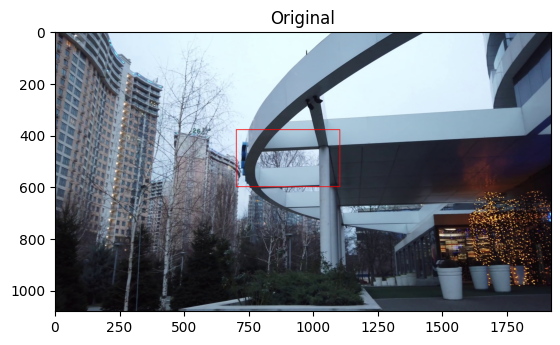

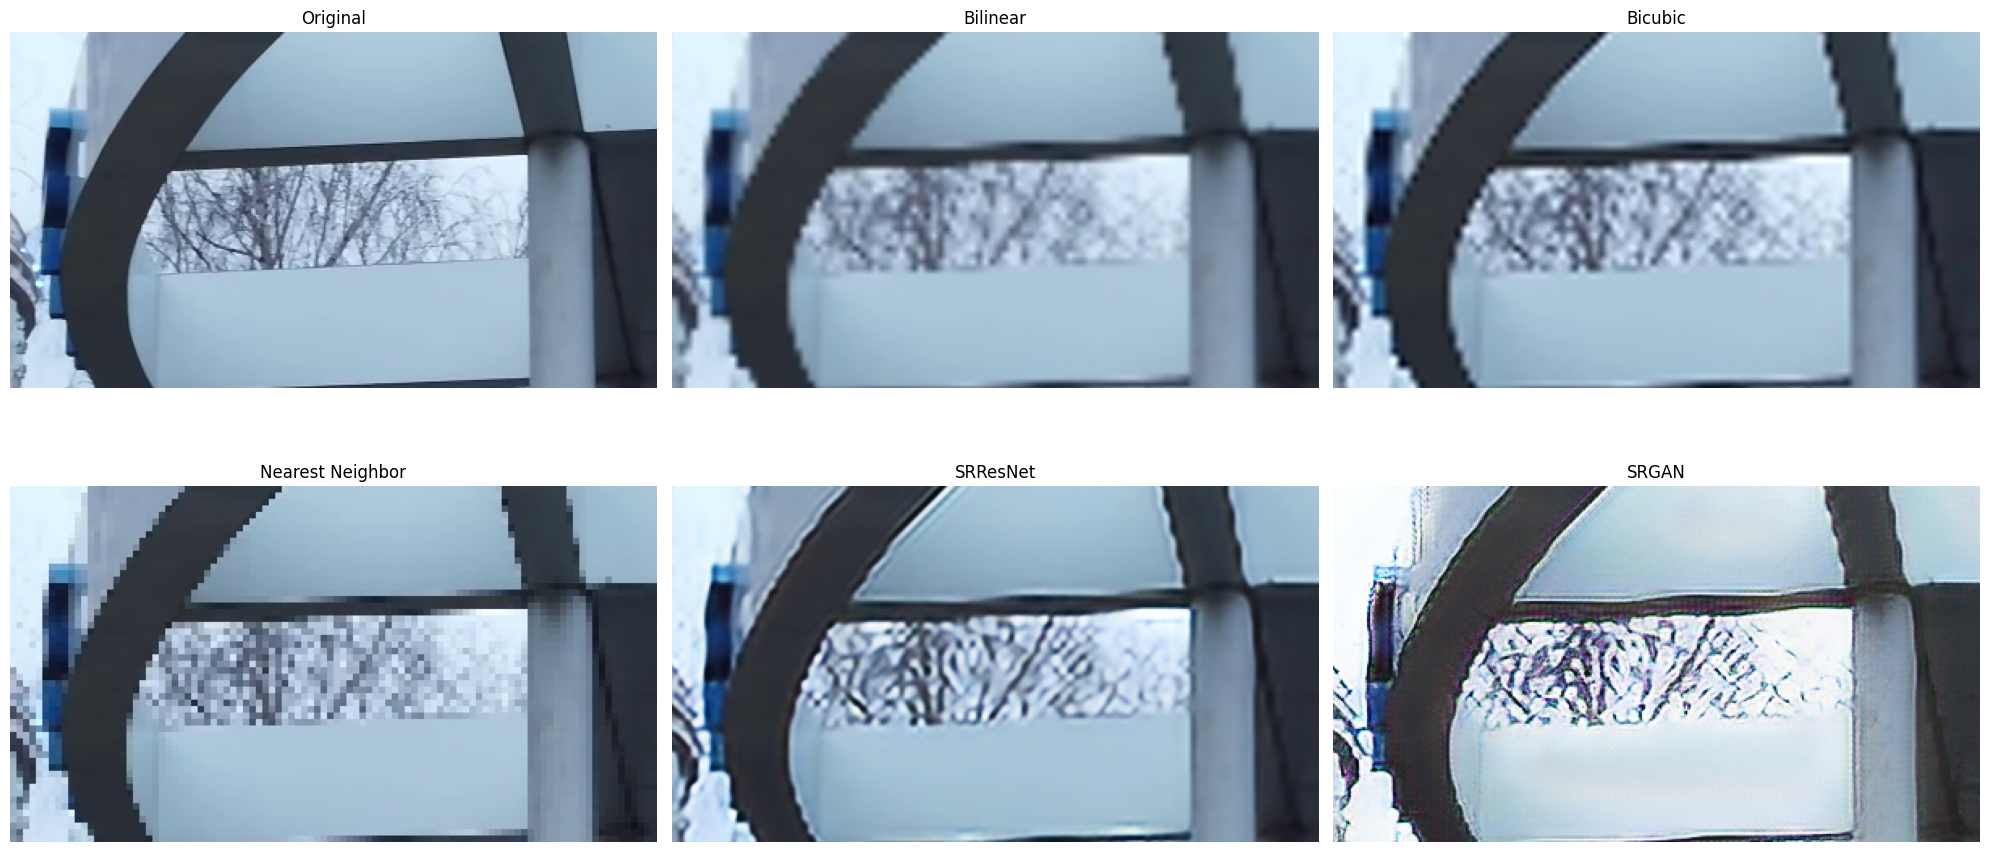

In [24]:

img_copy = img.copy()
# Draw a rectangle on the image between 400 and 600 pixels on the height and 700 and 1100 on the width
cv2.rectangle(img_copy, (700, 380), (1100, 600), (255, 0, 0), 2)

# Crop this rectangle in each image
img_cropped = img[380:600, 700:1100]
min_height,max_height,min_width,max_width = 380,600,700,1100
lr_cropped = lr[min_height//4:max_height//4, min_width//4:max_width//4]
# Convert the Image to a numpy array
img_resnet = np.array(img_resnet)
img_srgan = np.array(img_srgan)
img_resnet_cropped = img_resnet[380:600, 700:1100]
img_srgan_cropped = img_srgan[380:600, 700:1100]
img_bilinear_cropped = cv2.resize(lr, (lr.shape[1] * 4, lr.shape[0] * 4), interpolation=cv2.INTER_LINEAR)[380:600, 700:1100]
img_bicubic_cropped = cv2.resize(lr, (lr.shape[1] * 4, lr.shape[0] * 4), interpolation=cv2.INTER_CUBIC)[380:600, 700:1100]
img_nn_cropped = cv2.resize(lr, (lr.shape[1] * 4, lr.shape[0] * 4), interpolation=cv2.INTER_NEAREST)[380:600, 700:1100]

plt.imshow(img_copy)
plt.title("Original")
plt.show()

# Plot the images
fig, axes = plt.subplots(2, 3, figsize=(20, 10))
axes[0, 0].imshow(img_cropped)
axes[0, 0].set_title("Original")
axes[0, 1].imshow(img_bilinear_cropped)
axes[0, 1].set_title(f"Bilinear")
axes[0, 2].imshow(img_bicubic_cropped)
axes[0, 2].set_title(f"Bicubic")
axes[1, 0].imshow(img_nn_cropped)
axes[1, 0].set_title(f"Nearest Neighbor")
axes[1, 1].imshow(img_resnet_cropped)
axes[1, 1].set_title(f"SRResNet")
axes[1, 2].imshow(img_srgan_cropped)
axes[1, 2].set_title(f"SRGAN")
for ax in axes.flatten():
    ax.axis("off")
plt.tight_layout()
plt.show()



